## Описание задачи

Для телеком-компании нужно спрогнозировать отток клиентов. В случае если пользователь собирается уйти, ему могут быть предложены скидки. Для модели собраны данные о клиентах и их тарифах.

## План работ

1. Исследовательский анализ данных.
  - Изучить данные, обработать пропуски, привести типы данных, построить графики. Провести поиск выбивающихся значений. Сделать выводы о пользователях
2. Подготока к машинному обучению.
  - Определить, какие данные нужны для обучения, удалить лишнее. Объединить таблицы. Рассчитать дополнительные значения. Разбить данные на обучающую, тестовую части. Определить наличие дисбаланса, корелляцию признаков.
  - Закодировать категориальные признаки, попробовать классификацию на нескольких моделях.
  - При наличии дисбаланса, провести тесты с апсемплингом и даунсемплингом.
  - Подобрать лучшую модель при помощи кросс-валидации.
3. Провести финальное обучение модели, проверить при помощи тестовой выборки. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import Pool,CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

In [25]:
df_contracts = pd.read_csv("datasets/final_provider/contract.csv")
df_personal = pd.read_csv("datasets/final_provider/personal.csv")
df_internet = pd.read_csv("datasets/final_provider/internet.csv")
df_phone = pd.read_csv("datasets/final_provider/phone.csv")

In [26]:
#Функция описывает датасет - колонки, типы, пример данных

def show_df_info(df, df_name):
    print("Начало описания датасета \""+df_name+"\"-------------------------------------------------------------")
    display(df.info())
    display(df.sample(5))
    print("Конец описания датасета \""+df_name+"\"--------------------------------------------------------------")

In [27]:
#Функция описывает средние значения, выбросы, строит гистограмму.

def show_description(df, df_name):
    print("Начало описания датасета \""+df_name+"\"-------------------------------------------------------------")
    display(df.describe())
    display(df.sample(5))
    df.boxplot(vert=False, figsize = (15, 6))
    df.hist(bins = 50, figsize = (15, 6))
    print("Конец описания датасета \""+df_name+"\"--------------------------------------------------------------")

In [28]:
show_df_info(df_contracts, 'Информация о договоре')
show_df_info(df_personal, 'Персональные данные клиента')
show_df_info(df_internet, 'Информация об интернет-услугах')
show_df_info(df_phone, 'Информация об услугах телефонии')

Начало описания датасета "Информация о договоре"-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4065,7239-HZZCX,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,19.75,19.75
4338,9708-HPXWZ,2019-09-01,No,Month-to-month,No,Credit card (automatic),45.40,214.75
2263,2506-CLAKW,2019-05-01,2019-11-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),98.15,567.45
2029,6481-OGDOO,2014-03-01,2019-10-01 00:00:00,One year,Yes,Credit card (automatic),90.60,6056.15
458,4237-CLSMM,2019-12-01,No,Month-to-month,No,Mailed check,20.00,38


Конец описания датасета "Информация о договоре"--------------------------------------------------------------
Начало описания датасета "Персональные данные клиента"-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
5814,0787-LHDYT,Male,0,No,No
1608,2387-KDZQY,Male,0,No,No
3120,3148-AOIQT,Female,0,Yes,No
5416,8961-QDZZJ,Female,0,Yes,Yes
4647,7396-VJUZB,Male,0,Yes,Yes


Конец описания датасета "Персональные данные клиента"--------------------------------------------------------------
Начало описания датасета "Информация об интернет-услугах"-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3452,4636-JGAAI,Fiber optic,No,Yes,No,No,No,Yes
1744,1302-UHBDD,Fiber optic,No,No,No,No,Yes,Yes
1324,1442-OKRJE,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
3229,4632-XJMEX,DSL,Yes,Yes,No,Yes,No,No
1240,2660-EMUBI,Fiber optic,No,No,No,No,Yes,Yes


Конец описания датасета "Информация об интернет-услугах"--------------------------------------------------------------
Начало описания датасета "Информация об услугах телефонии"-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
4546,0052-DCKON,Yes
4110,6578-KRMAW,No
5308,9958-MEKUC,Yes
704,7314-OXENN,Yes
3200,8393-JMVMB,No


Конец описания датасета "Информация об услугах телефонии"--------------------------------------------------------------


В данных обнаружены колонки с типами, не соответствующими данным. Изменим их на оптимальные.

In [29]:
try:
    df_contracts['TotalCharges'] = pd.to_numeric(df_contracts['TotalCharges'], errors='coerce')
except:
    print('Возникла ошибка при приведении типов данных! Проверьте корректность заполнения файлов.')

Начало описания датасета "Информация о договоре"-------------------------------------------------------------


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6133,9638-JIQYA,2019-12-01,No,Month-to-month,Yes,Credit card (automatic),24.90,49.70
6962,0886-QGENL,2017-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,101.25,2754.45
3363,3474-BAFSJ,2015-05-01,No,Two year,Yes,Bank transfer (automatic),57.50,3265.95
3752,0412-UCCNP,2015-07-01,No,Two year,Yes,Electronic check,59.20,3175.85
1136,6621-NRZAK,2014-11-01,No,Two year,No,Credit card (automatic),20.00,1209.25


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Конец описания датасета "Информация о договоре"--------------------------------------------------------------


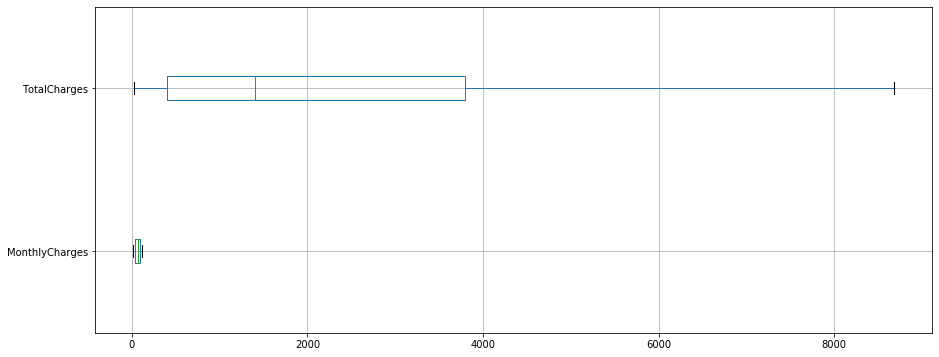

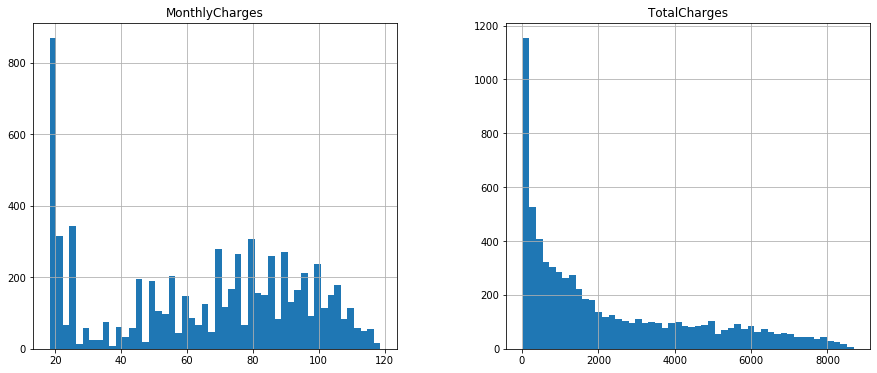

In [30]:
show_description(df_contracts, 'Информация о договоре')

Видим пустые значения в колонке TotalCharges. Выведем их:

In [31]:
display(df_contracts[df_contracts['TotalCharges'].isnull()])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Видно, что значения TotalCharges отсутствуют у клиентов, зарегистрированных датой среза. Данные о клиентах не полные и их количество небольшое, их лучше удалить.

In [32]:
df_contracts = df_contracts[df_contracts['TotalCharges'].notnull()]

Посмотрим на баланс классов в целевом признаке (уход клиента)

In [33]:
print("Пользователи которые не покинули нас: {:.0%}".format(df_contracts[df_contracts['EndDate'].isnull()]['customerID'].count()/df_contracts.shape[0]))
print("Пользователи которые покинули нас: {:.0%}".format(df_contracts[df_contracts['EndDate'].notnull()]['customerID'].count()/df_contracts.shape[0]))

Пользователи которые не покинули нас: 0%
Пользователи которые покинули нас: 100%


Видим, что распределение категорий клиентов неравномерное. Нужно будет учесть это при подготовке модели к машинному обучению. За весь срок от нас ушли 27% клиентов от общего количества, это очень большая цифра.

Посмотрим на распределение ухода клиентов по датам.

In [34]:
display(df_contracts[df_contracts['EndDate'].notnull()].groupby('EndDate')['customerID'].count())

EndDate
2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5163
Name: customerID, dtype: int64

Видим, что за весь срок клиенты уходили только в 4 даты, причем равномерным количеством чуть меньше 500 человек. Рекомендация бизнесу: изучить, что происходило накануне даты ухода. Возможно, происходили какие-то события которые повляли на одновременный уход такого большого количества клиентов.

Посмотрим на предпочтения пользователей по периодичности платежей. Из графика видно, что большинство пользователей предпочитают вносить оплату ежемесячно.

In [35]:
px.bar(df_contracts.pivot_table(values="customerID", index="Type", aggfunc="count").reset_index(), x="Type", y="customerID", title="Периодичность платежей", labels={'customerID':'Количество пользователей', 'Type':'Периодичность платежа'})

### Вывод

Для анализа нам было предоставлены данные о контрактах пользователей (7043 строк). Мы изучили эти данные, нашли пропуски, обработали типы данных. Был обнаружен дисбаланс в классах целевого признака - это важно для обучения модели. В поведении пользователей была выявлена аномалия - клиенты уходили только в определенные четыре даты (2019-10-01, 2019-11-01, 2019-12-01, 2020-01-01). Рекомендация для бизнеса: изучить события накануне этих дат, что могло привести к массовому уходу клиентов.

## Подготовка данных к обучению

Объединим даннные контрактов с данными по телефонии и интернету, а так же с личными данными пользователей.

In [36]:
df_full = df_contracts.set_index('customerID').join(df_phone.set_index('customerID'),
                                     how='left').join(df_internet.set_index('customerID'),
                                                      how='left').join(df_personal.set_index('customerID'),
                                                                       how='left').reset_index()

Удалим признаки, явно не влияющие на уход клиента. Добавим колонку - срок жизни контракта. Для этого заменим пустые строки даты ухода клиентов датой сбора данных. Целевой признак ухода клиента выразим в категориях 0 и 1 (0 - клиент ушел, 1 - клиент остался). На основе признака `MultipleLines` вычислим, пользуется ли клиент телефонией, на основе признака `InternetService` - пользуетя ли клиент услугами интернета. Колонка `SeniorCitizen` в данном датасете представлена как порядковое значение, хотя является категориальным. Вместо признака начала контракта введем признак год начала контракта.
Пропуски заполним новой категорией - "not used"

In [37]:
try:
    df_full['IsClient'] =  df_full['EndDate'].apply(lambda x: 1 if x=='No' else 0)
except:
    print('Проверьте наличие колонки EndDate')

try:
    to_datetime_fmt = partial(pd.to_datetime, format='%Y-%m-%d')
    df_full['BeginDate'] = df_full['BeginDate'].apply(to_datetime_fmt)
    to_datetime_fmt = partial(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
    df_full['EndDate'] = np.where(df_full['EndDate'] == 'No', '2020-02-01 00:00:00', df_full['EndDate'])
    df_full['EndDate'] = df_full['EndDate'].apply(to_datetime_fmt)
except:
    print('Вы уже меняли тип данных')


df_full['ConractLength'] = (df_full['EndDate'] - df_full['BeginDate']).dt.days
df_full['PhoneUser'] = df_full['MultipleLines'].apply(lambda x: 'No' if pd.isnull(x) else 'Yes')
df_full['InternetUser'] = df_full['InternetService'].apply(lambda x: 'No' if pd.isnull(x) else 'Yes')
df_full['IsSeniorCitizen'] =  df_full['SeniorCitizen'].apply(lambda x: 'No' if pd.isnull(x) else 'Yes')
df_full['YearStart'] = pd.DatetimeIndex(df_full['BeginDate']).year 

try:
    df_full.drop('Partner', axis=1, inplace=True)
    df_full.drop('Dependents', axis=1, inplace=True)
    df_full.drop('customerID', axis=1, inplace=True)
    df_full.drop('BeginDate', axis=1, inplace=True)
    df_full.drop('EndDate', axis=1, inplace=True)
    df_full.drop('SeniorCitizen', axis=1, inplace=True)
except:
    print("Колонки не найдены")

df_full.fillna("Not used", inplace=True)    
    
df_full.info()    
df_full#.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
gender              7032 non-null object
IsClient            7032 non-null int64
ConractLength       7032 non-null int64
PhoneUser           7032 non-null object
InternetUser        7032 non-null object
IsSeniorCitizen     7032 non-null object
YearStart           7032 non-null int64
dtypes: float64(2), int64(3), object(15)
memory usage: 1.1+ MB


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,IsClient,ConractLength,PhoneUser,InternetUser,IsSeniorCitizen,YearStart
0,Month-to-month,Yes,Electronic check,29.85,29.85,Not used,DSL,No,Yes,No,No,No,No,Female,1,31,No,Yes,Yes,2020
1,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No,Male,1,1036,Yes,Yes,Yes,2017
2,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No,Male,0,61,Yes,Yes,Yes,2019
3,One year,No,Bank transfer (automatic),42.30,1840.75,Not used,DSL,Yes,No,Yes,Yes,No,No,Male,1,1371,No,Yes,Yes,2016
4,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No,Female,0,61,Yes,Yes,Yes,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,One year,Yes,Mailed check,84.80,1990.50,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,1,730,Yes,Yes,Yes,2018
7028,One year,Yes,Credit card (automatic),103.20,7362.90,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,1,2191,Yes,Yes,Yes,2014
7029,Month-to-month,Yes,Electronic check,29.60,346.45,Not used,DSL,Yes,No,No,No,No,No,Female,1,337,No,Yes,Yes,2019
7030,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,Fiber optic,No,No,No,No,No,No,Male,0,123,Yes,Yes,Yes,2019


Проверим признаки на наличие мультиколлинеарности

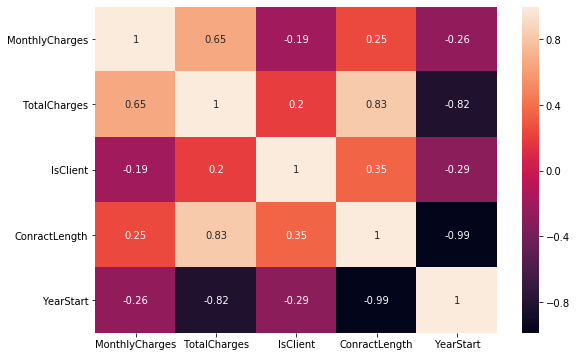

In [38]:
plt.figure(figsize = (9, 6))
ax = sns.heatmap(df_full.corr(), annot=True)

In [39]:
corr = df_full.loc[:, (~df_full.columns.isin(['IsClient']))].corr()
corr = corr.stack()
columns = corr[((corr > 0.8) | (corr < -0.8)) & (corr!=1)].reset_index()

columns

,level_0,level_1,0
0,TotalCharges,ConractLength,0.825811
1,TotalCharges,YearStart,-0.819304
2,ConractLength,TotalCharges,0.825811
3,ConractLength,YearStart,-0.987425
4,YearStart,TotalCharges,-0.819304
5,YearStart,ConractLength,-0.987425


Выявлена высока корелляция между признаками `TotalCharges` и `YearStart`, `ConractLength`. Удалим `YearStart`, `TotalCharges`

In [17]:
try:
    df_full.drop('YearStart', axis=1, inplace=True)
    df_full.drop('TotalCharges', axis=1, inplace=True)
except:
    print("Колонки не найдены")

### Кодирование категориальных признаков

Закодируем категориальные признаки методами OHE и ordinal.

In [18]:
df_ohe = pd.get_dummies(df_full, drop_first=True)
df_ohe.head()

,MonthlyCharges,IsClient,ConractLength,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Not used,...,DeviceProtection_Yes,TechSupport_Not used,TechSupport_Yes,StreamingTV_Not used,StreamingTV_Yes,StreamingMovies_Not used,StreamingMovies_Yes,gender_Male,PhoneUser_Yes,InternetUser_Yes
0,29.85,1,31,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,56.95,1,1036,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
2,53.85,0,61,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
3,42.30,1,1371,1,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1
4,70.70,0,61,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [19]:
train_ohe, valid_ohe = train_test_split(df_ohe, test_size=0.4, random_state=12345, stratify=df_ohe['IsClient'])
valid_ohe, test_ohe = train_test_split(valid_ohe, test_size=0.5, random_state=12345, stratify=valid_ohe['IsClient'])

train_features_ohe = train_ohe.drop('IsClient', axis=1)
train_target_ohe = train_ohe['IsClient']
valid_features_ohe = valid_ohe.drop('IsClient', axis=1)
valid_target_ohe = valid_ohe['IsClient']

In [20]:
cat_features = ['Type','PaperlessBilling','PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','gender','PhoneUser','InternetUser',
                'IsSeniorCitizen']
encoder = OrdinalEncoder()
df_ord=df_full.copy()
df_ord[cat_features] = encoder.fit_transform(df_ord[cat_features])

In [21]:
train_ord, valid_ord = train_test_split(df_ord, test_size=0.4, random_state=12345, stratify=df_ord['IsClient'])
valid_ord, test_ord = train_test_split(valid_ord, test_size=0.5, random_state=12345, stratify=valid_ord['IsClient'])

train_features_ord = train_ord.drop('IsClient', axis=1)
train_target_ord = train_ord['IsClient']
valid_features_ord = valid_ord.drop('IsClient', axis=1)
valid_target_ord = valid_ord['IsClient']

In [22]:
#Разделим на датасеты данные без обработки
train_full, valid_full = train_test_split(df_full, test_size=0.4, random_state=12345, stratify=df_full['IsClient'])
valid_full, test_full = train_test_split(valid_full, test_size=0.5, random_state=12345, stratify=valid_full['IsClient'])

train_features_full = train_full.drop('IsClient', axis=1)
train_target_full = train_full['IsClient']
valid_features_full = valid_full.drop('IsClient', axis=1)
valid_target_full = valid_full['IsClient']
test_features_full = test_full.drop('IsClient', axis=1)
test_target_full = test_full['IsClient']

### Выбор лучшей модели

In [23]:
#Функция обучения и проверки модели
def get_metrics(model, train_features, train_target, valid_features, valid_target):
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    probabilities_valid = model.predict_proba(valid_features)
    probabilities_one_valid = probabilities_valid[:, 1]
    accuracy = accuracy_score(valid_target, predictions)
    roc_auc = roc_auc_score(valid_target, probabilities_one_valid)
    return (accuracy, roc_auc)

In [24]:
lr_model = LogisticRegression(solver = 'liblinear', random_state = 12345)
metrics_lr_ohe = get_metrics(lr_model, train_features_ohe, train_target_ohe, valid_features_ohe, valid_target_ohe)
print("Логистическая регрессия. OHE обработка. Accuracy: ", metrics_lr_ohe[0])
print("Логистическая регрессия. OHE обработка. AUC-ROC: ", metrics_lr_ohe[1])

rand_forest_model = RandomForestClassifier(random_state=12345)
metrics_rf_ord = get_metrics(rand_forest_model, train_features_ord, train_target_ord, valid_features_ord, valid_target_ord)
print("Случайный лес. Ordinal обработка. Accuracy: ", metrics_rf_ord[0])
print("Случайный лес. Ordinal обработка. AUC-ROC: ", metrics_rf_ord[1])

metrics_rf_ohe = get_metrics(rand_forest_model, train_features_ohe, train_target_ohe, valid_features_ohe, valid_target_ohe)
print("Случайный лес. OHE обработка. Accuracy: ", metrics_rf_ohe[0])
print("Случайный лес. OHE обработка. AUC-ROC: ", metrics_rf_ohe[1])

Логистическая регрессия. OHE обработка. Accuracy:  0.8079658605974396
Логистическая регрессия. OHE обработка. AUC-ROC:  0.8550747730381792
Случайный лес. Ordinal обработка. Accuracy:  0.8093883357041252
Случайный лес. Ordinal обработка. AUC-ROC:  0.8486040293495833
Случайный лес. OHE обработка. Accuracy:  0.8108108108108109
Случайный лес. OHE обработка. AUC-ROC:  0.8447345375782448


In [25]:
model = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC', learning_rate=0.1)

train_pool = Pool(train_features_full, train_target_full, cat_features)
test_pool = Pool(valid_features_full, valid_target_full, cat_features) 

model.fit(train_pool,
          verbose=False)

pred_proba = model.predict_proba(test_pool)[:, 1]
preds_class = model.predict(test_pool)

metrics_cb = []
metrics_cb.append(accuracy_score(valid_target_full, preds_class))
metrics_cb.append(roc_auc_score(valid_target_full, pred_proba))

print("CatBoostClassifier. Accuracy: ", metrics_cb[0])
print("CatBoostClassifier. AUC-ROC: ", metrics_cb[1])

CatBoostClassifier. Accuracy:  0.8677098150782361
CatBoostClassifier. AUC-ROC:  0.9179077021929279


Рассмотрим важность признаков для catboost. Удалим наименее используемые.

Text(0.5, 1.0, 'Важность признаков CatBoost')

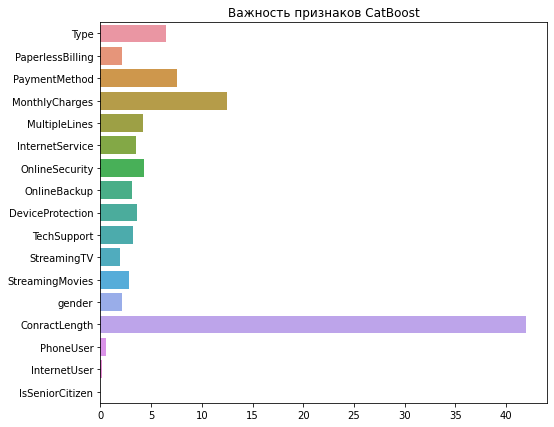

In [26]:
plt.figure(figsize = (8, 7))
sns.barplot(y=valid_features_full.columns, x=model.feature_importances_, orient='h')
plt.title('Важность признаков CatBoost')

Удалим наименее важные признаки

In [27]:
try:
    train_features_full.drop(labels=['StreamingTV', 'IsSeniorCitizen', 'InternetUser',
                                     'PhoneUser','gender'], axis=1, inplace=True)
    valid_features_full.drop(labels=['StreamingTV', 'IsSeniorCitizen', 'InternetUser',
                                     'PhoneUser','gender'], axis=1, inplace=True)
    test_features_full.drop(labels=['StreamingTV', 'IsSeniorCitizen', 'InternetUser',
                                     'PhoneUser','gender'], axis=1, inplace=True)
except:
    print("Колонки не найдены")

Сравним полученные параметры.

In [28]:
transpose = np.array([['Accuracy','AUC-ROC'], metrics_lr_ohe, metrics_rf_ord, metrics_rf_ohe, metrics_cb]).T.tolist()
models_compare = pd.DataFrame(transpose, columns=['Метрика','Логистическая регрессия. OHE', 'Случайный лес. Ordinal', 
                                                       'Случайный лес. OHE', 'CatBoostClassifier'])
models_compare

,Метрика,Логистическая регрессия. OHE,Случайный лес. Ordinal,Случайный лес. OHE,CatBoostClassifier
0,Accuracy,0.8079658605974396,0.8093883357041252,0.8108108108108109,0.8677098150782361
1,AUC-ROC,0.8550747730381792,0.8486040293495833,0.8447345375782448,0.9179077021929279


Видим, что лучшие результаты нам дает CatBoostClassifier, на втором месте - логистическая регрессия.

### Подбор гиперпараметров моделей

Для подбора гиперпараметров и тестов используем две лучшие модели - Логистическую регрессию и CatBoostClassifier

In [29]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [30]:
%%time
lr_model = LogisticRegression(solver = 'liblinear')
grid={"C":np.logspace(-3,3,20), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(lr_model,grid,scoring=roc_auc_scorer,cv=5)
logreg_cv.fit(train_features_ohe, train_target_ohe)

print("Лучшие параметры для логистической регрессии: ",logreg_cv.best_params_)
print("Логистическая регрессия. AUC-ROC: ",logreg_cv.best_score_)

Лучшие параметры для логистической регрессии:  {'C': 0.6951927961775606, 'penalty': 'l1'}
Логистическая регрессия. AUC-ROC:  0.8439296155018543
Wall time: 4.52 s


In [31]:
%%time
from sklearn.preprocessing import LabelEncoder
model = CatBoostClassifier(eval_metric='AUC')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3],
        'loss_function': ['Logloss', 'CrossEntropy']}

Grid_CBC = GridSearchCV(estimator=model, param_grid = grid, cv = 5, scoring=roc_auc_scorer, n_jobs=-1)
X_train_enc = train_features_full.apply(LabelEncoder().fit_transform)
Grid_CBC.fit(X_train_enc, train_target_full)
print("CatBoostClassifier. AUC-ROC: ",Grid_CBC.best_score_)
print("CatBoostClassifier. Лучшие параметры: ",Grid_CBC.best_params_)

0:	total: 2.16ms	remaining: 430ms
1:	total: 4.48ms	remaining: 443ms
2:	total: 6.53ms	remaining: 429ms
3:	total: 8.71ms	remaining: 427ms
4:	total: 10.6ms	remaining: 415ms
5:	total: 12.6ms	remaining: 406ms
6:	total: 14.5ms	remaining: 400ms
7:	total: 16.7ms	remaining: 402ms
8:	total: 18.9ms	remaining: 401ms
9:	total: 21.1ms	remaining: 400ms
10:	total: 23.2ms	remaining: 399ms
11:	total: 25.3ms	remaining: 396ms
12:	total: 27.1ms	remaining: 389ms
13:	total: 29ms	remaining: 385ms
14:	total: 31.3ms	remaining: 387ms
15:	total: 33.2ms	remaining: 382ms
16:	total: 35.5ms	remaining: 382ms
17:	total: 37.5ms	remaining: 379ms
18:	total: 39.7ms	remaining: 379ms
19:	total: 42ms	remaining: 378ms
20:	total: 44.2ms	remaining: 377ms
21:	total: 46.2ms	remaining: 374ms
22:	total: 48.4ms	remaining: 373ms
23:	total: 50.6ms	remaining: 371ms
24:	total: 52.7ms	remaining: 369ms
25:	total: 54.9ms	remaining: 367ms
26:	total: 57.1ms	remaining: 366ms
27:	total: 59ms	remaining: 362ms
28:	total: 60.8ms	remaining: 359ms
2

При подборе гиперпараметров модель CatBoostClassifier показывает лучшее значение метрик. Выберем ее для финального тестирования.

## Финальное тестирование модели с лучшими гиперпараметрами

In [34]:
cat_features = ['Type','PaperlessBilling','PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                'DeviceProtection','TechSupport','StreamingMovies']
model = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC', learning_rate=0.25, depth=4, iterations=200, l2_leaf_reg=0.2)
train_pool = Pool(train_features_full, train_target_full, cat_features)
test_pool = Pool(test_features_full, test_target_full, cat_features) 

model.fit(train_pool,
          verbose=False)

pred_proba = model.predict_proba(test_pool)[:, 1]
preds_class = model.predict(test_pool)

print("CatBoostClassifier. Accuracy: ", accuracy_score(test_target_full, preds_class))
print("CatBoostClassifier. AUC-ROC: ", roc_auc_score(test_target_full, pred_proba))

CatBoostClassifier. Accuracy:  0.8699360341151386
CatBoostClassifier. AUC-ROC:  0.9176972734002516


## Вывод

Мы выбрали лучшую модель - CatBoostClassifier. Эта модель дала нам метрику AUC-ROC = 0.91.  Она обучается дольше, но дает значительно лучший результат метрик. В случае, если у бизнеса нет времени ждать долго, а данных для обучения будет значительно больше, для обучения можно взять логистическую регрессию.